<h1>Descrizione Del Problema</h1>
Valutare se l'analisi di un dataset derivante dalla combinazione di due precedenti con features simili (eseguita con più modelli), risulta più efficace rispetto ad un'analisi su i due dataset in maniera distina.
<h3>Motivazione del problema</h3>

Lo scopo di questo progetto è confutare se: l'analisi di un modello su un dataset combinato è più affidabili rispetto ad un'analisi su due dataset distinti con features simili.

<h1>Soluzione Proposta</h1>

La soluzione proposta è quella di, dato il dataset combinato, allenare con quest'ultimo diversi modelli di machine learning per calcolare diversi fattori, quali accuracy e recall, che misurano la bontà di tali modelli nella predizione. Calcolare poi, utilizzando shap, il peso delle singole features sull'output dei modelli al fine di analizzare quelle più rilevanti.



<h1>Sfide informatiche affrontate</h1>
<ul style="line-height: 30px;">
<li>Modellazione del problema</li>
<li>Normalizzazione delle features dei datasets (one hot encoding)</li>
<li>Bilanciamento dei datasets (ADASYN)</li>
<li>Utilizzo di Shap per l'analisi del peso delle features</li>
<li>Analisi del comportamento dei modelli</li>
</ul>

<h1>Risultati ottenuti in sintesi.</h1>
<h4>Alcuni dei modelli che utilizzano il dataset combinato (ictus e diabete) presentano un'accuratezza e una recall migliore rispetto ai modelli che sfruttano i dataset in maniera separata.</h4>
<h4 style="text-align: center;">Confusion Matrix Disease<h4>


<img src="img/confusion_matrix_disease.png" title="Confusion Matrix Disease"></img>

<h4 style="text-align: center;">Confusion Matrix Diabete<h4>
<img src="img/confusion_matrix_diabete.png" title="Confusion Matrix Diabete"></img>

<h4 style="text-align: center;">Confusion Matrix Stroke<h4>
<img src="img/confusion_matrix_stroke.png" title="Confusion Matrix Stroke"></img>

<h1>Metodo Proposto</h1>
<ul style="line-height: 30px;">
<li>Merge dei due dataset stroke e diabetes</li>
<li>Normalizzazione delle features</li>
<li>Analisi del dataset risultante</li>
<li>Split del dataset in train e <b><u>test</b></u> </li>
<li>Valutazione tecniche di oversampling per il bilanciamento del <b><u>test</b></u></li>
<li>Calcolo della varianza con diversi seed</li>
<li>Addestramento su tre modelli distinti (Random Forest, K Neighbour, Logistic Regression)</li>
<li>Calcolo della matrice di confusione con Recall ed Accuracy dei modelli</li>
<li>Utilizzo del framework Shap per valutare il peso delle singole features del dataset</li>
</ul>

In [14]:
import sys
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings("ignore")

In [15]:
df_stroke = pd.read_csv("../../data/stroke_datasets/stroke.csv")
df_diabetes = pd.read_csv("../../data/diabetes_datasets/diabetes.csv")

print("-----------Stroke Dataset---------- \n")
print(df_stroke.head())
print("\n-----------Diabetes Dataset---------- \n")
print(df_diabetes.head())

-----------Stroke Dataset---------- 

   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  

-----------Diabetes Dataset---------- 

   gender   age  hypertension  heart_disease smoki

<h1>Normalizzazione dei Datasets (stroke Diabete)</h1>
<h3>Presi in input i due dataset:</h3>
<ul style="line-height: 30px;">
<li>si elimano gli eventuali valori NaN;</li>
<li>si effettua una codifica one hot su le fetures categoriche;</li>
<li>si convertono le fetures booleane in integer</li>
</ul>

In [16]:
#Replace NaN bmi values
df_stroke["bmi"] = df_stroke["bmi"].replace(np.NaN, df_stroke["bmi"].mean())
df_stroke['bmi'] = df_stroke['bmi'].round(2)

#one hot encoding stroke 
df_encoded_stroke = pd.get_dummies(df_stroke, columns = ['gender', 'smoking_status','ever_married','work_type','Residence_type'])
df_encoded_stroke['id'] = range(1, len(df_encoded_stroke) + 1)

#convert the boolean features in integer (0,1)
boolean_columns = df_encoded_stroke.select_dtypes(include=bool).columns
for column in boolean_columns:
    df_encoded_stroke[column] = df_encoded_stroke[column].astype(int)

print(df_encoded_stroke.head())


    age  hypertension  heart_disease  avg_glucose_level    bmi  stroke  \
0  67.0             0              1             228.69  36.60       1   
1  61.0             0              0             202.21  28.89       1   
2  80.0             0              1             105.92  32.50       1   
3  49.0             0              0             171.23  34.40       1   
4  79.0             1              0             174.12  24.00       1   

   gender_Female  gender_Male  gender_Other  smoking_status_Unknown  ...  \
0              0            1             0                       0  ...   
1              1            0             0                       0  ...   
2              0            1             0                       0  ...   
3              1            0             0                       0  ...   
4              1            0             0                       0  ...   

   ever_married_No  ever_married_Yes  work_type_Govt_job  \
0                0                 1  

In [17]:

#one hot encoding diabetes
df_encoded_diabetes = pd.get_dummies(df_diabetes, columns = ['gender', 'smoking_history'])
df_encoded_diabetes['id'] = range(len(df_encoded_stroke) + 1, len(df_encoded_diabetes) + len(df_encoded_stroke) + 1)

#convert the boolean features in integer (0,1)
boolean_columns_new = df_encoded_diabetes.select_dtypes(include=bool).columns
for column in boolean_columns_new:
    df_encoded_diabetes[column] = df_encoded_diabetes[column].astype(int)

print(df_encoded_diabetes.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  gender_Other  \
0         0              1            0             0   
1         0              1            0             0   
2         0              0            1             0   
3         0              1            0             0   
4         0              0            1             0   

   smoking_history_No Info  smoking_history_current  smoking_history_ever  \
0                        0                        0                     0   
1               

<h3>Dopo aver normalizzato i due dataset in one hot encoded per eseguire il merge dei due dataset:</h3>
<ul style="line-height: 30px;">
<li>si sono rinominate le features uguali dei due dataset;</li>
<li>si sono normalizzati i valori NaN dati dal merge;</li>
</ul>

In [18]:

df_ictus_up = df_encoded_stroke.rename(columns={'smoking_status_Unknown': 'smoking_history_No Info', 'smoking_status_formerly smoked': 'smoking_history_former', 
                                    'smoking_status_never smoked': 'smoking_history_never', 'smoking_status_smokes': 'smoking_history_ever',
                                    'stroke': 'disease', 'avg_glucose_level': 'blood_glucose_level'})

df_ictus_up["bmi"] = df_ictus_up["bmi"].replace(np.NaN, df_ictus_up["bmi"].mean())
df_ictus_up['bmi'] = df_ictus_up['bmi'].round(2)
df_diabetes_up = df_encoded_diabetes.rename(columns={'diabetes': 'disease'})

#merge
concatenated_data = pd.concat([df_ictus_up, df_diabetes_up], ignore_index=True)


boolean_columns={'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban','smoking_history_current','smoking_history_not current'}
#Sobstitution of NaN values of the boolean Features 
for column in boolean_columns:
    null_indices = concatenated_data[column].isnull()  # Trova gli indici dei valori NaN
    random_values = np.random.rand(sum(null_indices))  # Genera valori casuali tra 0 e 1
    concatenated_data.loc[null_indices, column] = random_values  # Sostituisci i valori NaN con i valori casuali
    concatenated_data[column] = concatenated_data[column].apply(lambda x: False if x < 0.5 else True)  # Converte i valori in False o True

concatenated_data['HbA1c_level'] = concatenated_data['HbA1c_level'].replace(np.NaN, concatenated_data['HbA1c_level'].mean())
concatenated_data['HbA1c_level'] = concatenated_data['HbA1c_level'].round(2)

#convert the boolean features in integer (0,1) 
boolean_columns_new = concatenated_data.select_dtypes(include=bool).columns
for column in boolean_columns_new:
    concatenated_data[column] = concatenated_data[column].astype(int)

print(concatenated_data.head())


    age  hypertension  heart_disease  blood_glucose_level    bmi  disease  \
0  67.0             0              1               228.69  36.60        1   
1  61.0             0              0               202.21  28.89        1   
2  80.0             0              1               105.92  32.50        1   
3  49.0             0              0               171.23  34.40        1   
4  79.0             1              0               174.12  24.00        1   

   gender_Female  gender_Male  gender_Other  smoking_history_No Info  ...  \
0              0            1             0                        0  ...   
1              1            0             0                        0  ...   
2              0            1             0                        0  ...   
3              1            0             0                        0  ...   
4              1            0             0                        0  ...   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0

<h3>Fase di oversampling con ADASYN</h3>
<p>ADASYN, Si concentra sulle istanze della minoranza che sono difficili da classificare correttamente, anziché eseguire un sovracampionamento uniforme di tutte le istanze della minoranza. Assegna un peso diverso a ciascuna istanza della minoranza in base al suo livello di difficoltà nella classificazione</p>

In [19]:

# Separate the features (X) and the labels (y)
X = concatenated_data.drop(['disease','id'], axis=1)
y = concatenated_data['disease'] 

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=43)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Create a new DataFrame with the balanced data
data_adasyn = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_adasyn['bmi'] = data_adasyn['bmi'].round(2)
data_adasyn['age'] = data_adasyn['age'].astype(int)

In [20]:
# Read the dataset
data_standard = concatenated_data
def plot_disease_pie_chart(dataframe):
    #Pie Plot
    disease_0 = dataframe.loc[dataframe["disease"] == 0, :].shape[0]
    disease_1 = dataframe.loc[dataframe["disease"] == 1, :].shape[0]

    labels = ["With disease", "Without disease"]
    sizes = [disease_1, disease_0]
    colors = ["#F57163", "#B2F57E"]
    plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", textprops={'fontsize': 18})
    plt.title("Number of record per 'disease'")
    plt.plot()




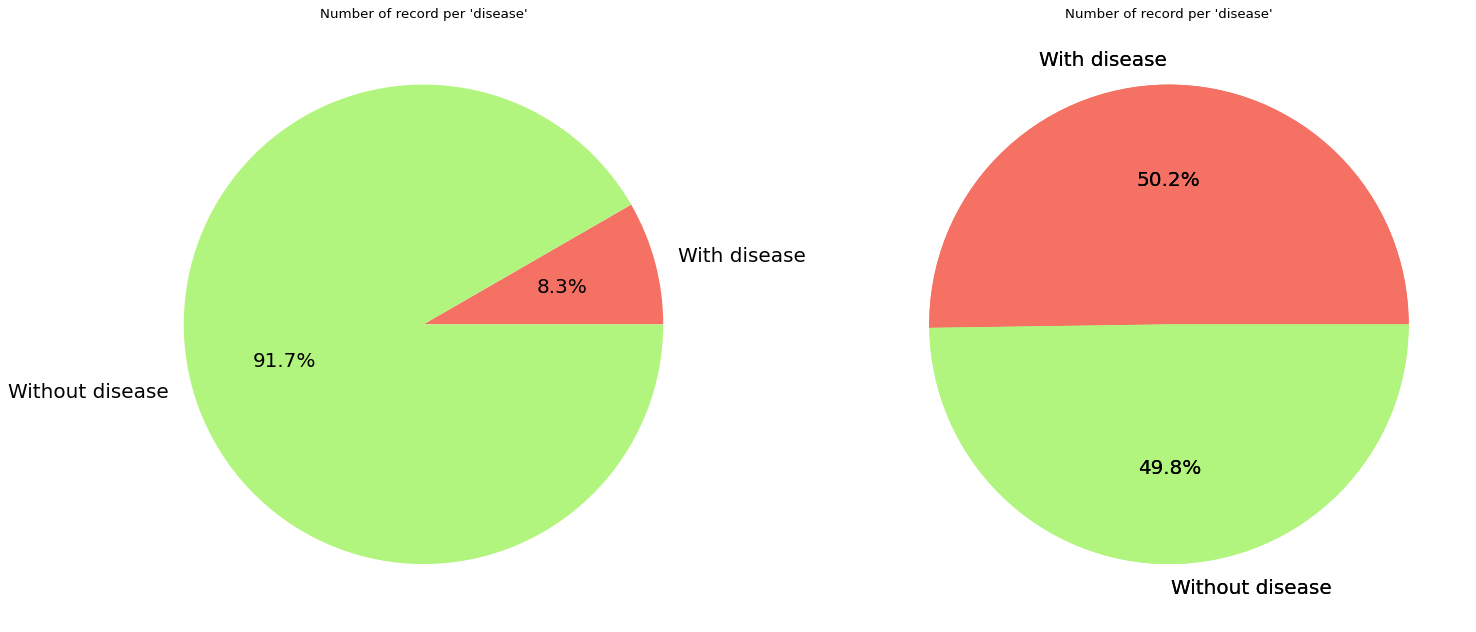

In [21]:
plt.figure(figsize=(20, 8), dpi=80)  # Adjust width, height, and dpi as needed
plt.subplot(1, 2, 1)
plot_disease_pie_chart(data_standard)
plt.subplot(1, 2, 2)
plot_disease_pie_chart(data_adasyn)
plt.tight_layout()
plot_disease_pie_chart(data_adasyn)
plt.tight_layout()
plt.show()

<h3>Calcolo della varianza dei modelli</h3>
<h4>Tramite più esecuzioni attraverso l'utilizzo di 30 seed distinti</h4>

In [22]:
X_standard = data_standard.drop(['disease','id'], axis=1)
y_standard = data_standard['disease']

start = 42
maxIter = 30
step = 100
results_random_forest = []
results_k = []
results_log_reg = []
i = 0
while i < maxIter:
    seed = np.random.seed(42 + step)
    # Apply ADASYN to oversample the minority class
    adasyn = ADASYN(random_state=seed)
    X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=seed)
   
    X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)

    # Fit models on X_train and y_train without oversampling
    model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
    model_k = KNeighborsClassifier().fit(X_train_sta, y_train_sta)
    model_log_reg = LogisticRegression().fit(X_train_sta, y_train_sta)

    # Prediction on oversampled X_test_sta (X_test_ada)
    pred_random_forest = model_random_forest.predict(X_test_ada)
    pred_k = model_k.predict(X_test_ada)
    pred_log_reg = model_log_reg.predict(X_test_ada)

    # Accuracy for the models
    accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)
    accuracy_k = accuracy_score(y_test_ada, pred_k)
    accuracy_log_reg = accuracy_score(y_test_ada, pred_log_reg)

    # Append the result of each iteration for the accuracy of the models in a list 
    results_random_forest.append(accuracy_random_forest)
    results_k.append(accuracy_k)
    results_log_reg.append(accuracy_log_reg)
    i = i + 1
    step = step + 100
# Compute the variance for the models
variance_random_forest = np.var(results_random_forest)
variance_k = np.var(results_k)
variance_log_reg = np.var(results_log_reg)

In [23]:
print("Random Forest Variance: ", variance_random_forest)
print("K Neighbour Variance: ", variance_k)
print("Logistic Regression Variance: ", variance_log_reg)

Random Forest Variance:  1.8259699159474116e-05
K Neighbour Variance:  1.561807809730476e-05
Logistic Regression Variance:  0.0010488681651716761


In [24]:
# Declaration of ADASYN to oversample the minority class using the starting seed
adasyn = ADASYN(random_state=start)

# Split of data in train and test using the starting seed
X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=start)
# Oversampling of the minority class trough ADASYN
X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)


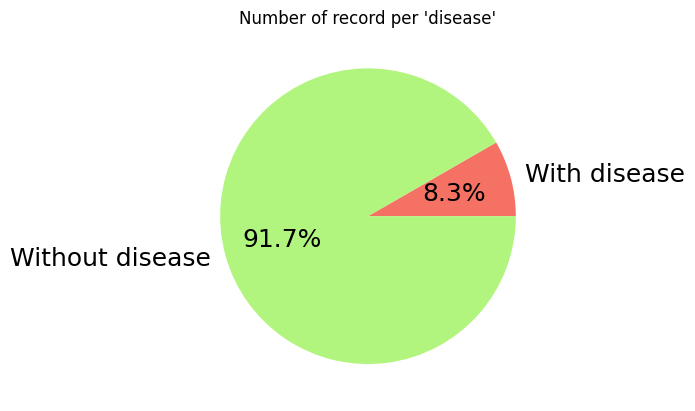

In [25]:
#Check frequency disease on test split without oversampling 
y_test_sta_df = pd.DataFrame({'disease': y_test_sta})
plot_disease_pie_chart(y_test_sta_df)
plt.show()

<h1>Training Dei Modelli</h1>
<h3>Modelli utilizzati:</h3>
<ul style="line-height: 30px;">
<li>Random Forest</li>
<li>Logistic Regression</li>
<li>K Neighbors</li>
</ul>

In [26]:
 #------------ KNeighborsClassifier ------------
model_k =  KNeighborsClassifier().fit(X_train_sta, y_train_sta)
pred_k = model_k.predict(X_test_ada)

#------------ RandomForestClassifier ------------
model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
pred_random_forest = model_random_forest.predict(X_test_ada)

#------------ LogisticRegression ------------
model_logistic =  LogisticRegression().fit(X_train_sta, y_train_sta)
pred_logistic = model_logistic.predict(X_test_ada)

In [27]:
# Calculate the confusion matrix for the model KNeighborsClassifier
confusion_matrix_k = confusion_matrix(y_test_ada, pred_k)
accuracy_k = accuracy_score(y_test_ada, pred_k)*100
recall_k = recall_score(y_test_ada, pred_k)

# Calculate the confusion matrix for the model RandomForestClassifier
confusion_matrix_random_forest = confusion_matrix(y_test_ada, pred_random_forest)
accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)*100
recall_random_forest = recall_score(y_test_ada, pred_random_forest)

# Calculate the confusion matrix for the model LogisticRegression
confusion_matrix_logistic = confusion_matrix(y_test_ada, pred_logistic)
accuracy_logistic = accuracy_score(y_test_ada, pred_logistic)*100
recall_logistic = recall_score(y_test_ada, pred_logistic)

In [28]:
#Function to plot the confusion matrix of a model
def plot_matrix_model(model,accuracy,recall,confusion_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        confusion_matrix.flatten()/np.sum(confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title("Confusion Matrix {:s} \nAccuracy={:.2f}  Recall={:.2f}".format(model,accuracy, recall))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    # Display the visualization of the Confusion Matrix.
    plt.plot()

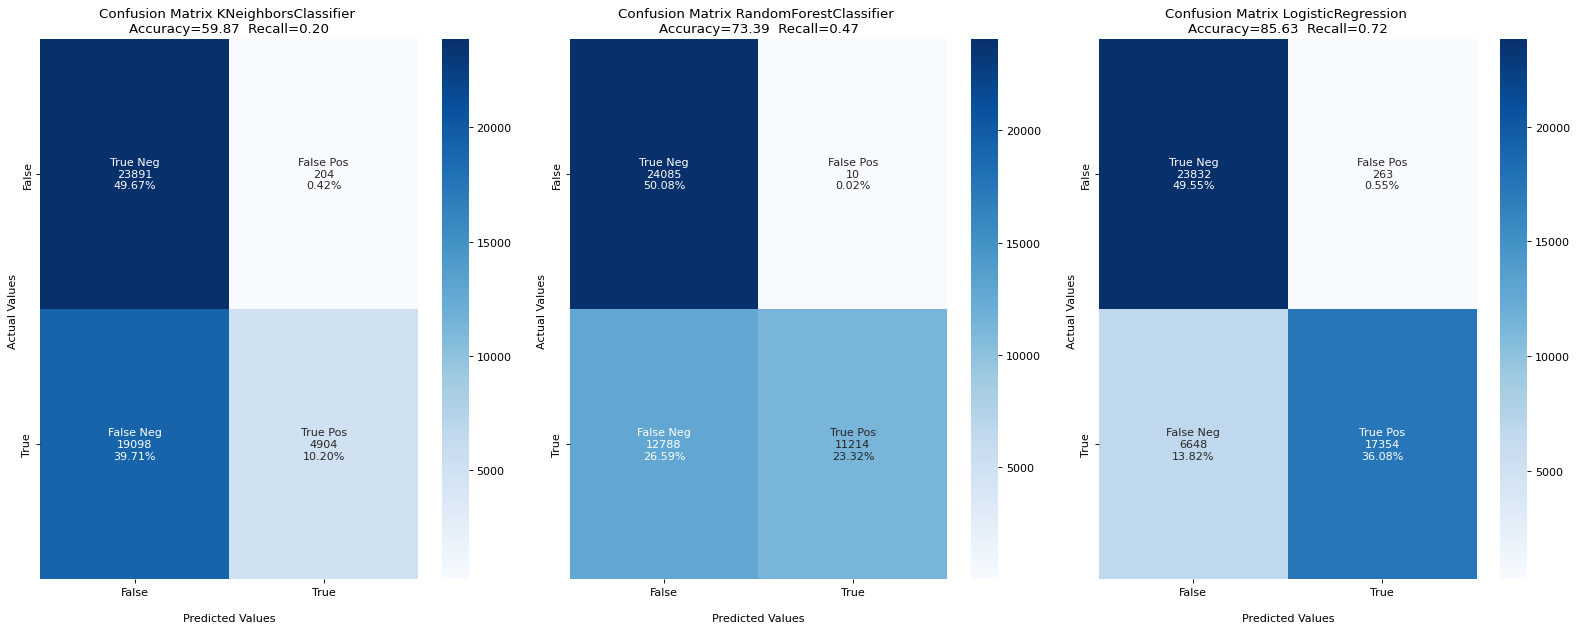

In [29]:
plt.figure(figsize=(20, 8), dpi=80)
plt.subplot(1, 3, 1)
plot_matrix_model("KNeighborsClassifier",accuracy_k,recall_k,confusion_matrix_k)
plt.subplot(1, 3, 2)
plot_matrix_model("RandomForestClassifier",accuracy_random_forest,recall_random_forest,confusion_matrix_random_forest)
plt.subplot(1, 3, 3)
plot_matrix_model("LogisticRegression",accuracy_logistic,recall_logistic,confusion_matrix_logistic)
plt.tight_layout()
plt.show()

<h1>Analisi dei modelli tramite SHAP</h1>
<h3>SHAP (SHapley Additive exPlanations) è un approccio teorico dei giochi per spiegare l'output di qualsiasi modello di machine learning. Può dirci come ciascuna features del modello ha contribuito per una singola previsione.</h3>

In [30]:
#Compute the explainer for shap for the models
explainer_random_forest = shap.Explainer(model_random_forest.predict, X_test_ada)
explainer_k = shap.Explainer(model_k.predict, X_test_ada)
explainer_linear = shap.Explainer(model_logistic.predict, X_test_ada)

#Compute the shap values for the models
shap_values_random_forest = explainer_random_forest(X_standard[4000:7000])
shap_values_k = explainer_k(X_standard[5050:5150])
shap_values_linear = explainer_linear(X_standard[5050:5150])

PermutationExplainer explainer: 3001it [10:58,  4.53it/s]                          
PermutationExplainer explainer: 101it [03:08,  1.99s/it]                         


<h1>Bar Chart</h1>
<p>La feature "HbA1c_level" rappresenta il livello di emoglobina glicosilata nel sangue, che si crea nel momento in cui il livello di glucosia è troppo alto e esso si lega con la molecola di emoglobina dando vita all'emoglobina glicosilata che rende più lento il trasporto di ossigeno nel corpo tramite il sangue.</p>
<br>
<p>Dall'analisi dei grafici abbiamo constatato che le features più rilevanti secondo i modelli utilizzati sono:</p>
<ul>
<li>HbA1c_level</li>
<li>age</li>
<li>bmi</li>
<li>blood_glucose_level</li>
<li>gender_Female</li>
<li>gender_Male</li>
</ul>

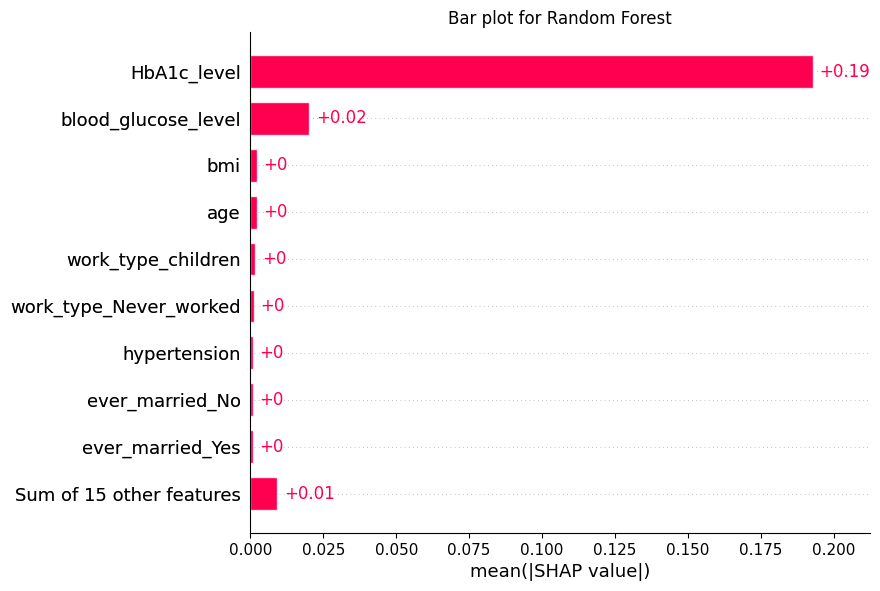

In [31]:
#bar plot for models
shap.plots.bar(shap_values_random_forest, show=False)
plt.title("Bar plot for Random Forest")
plt.show()

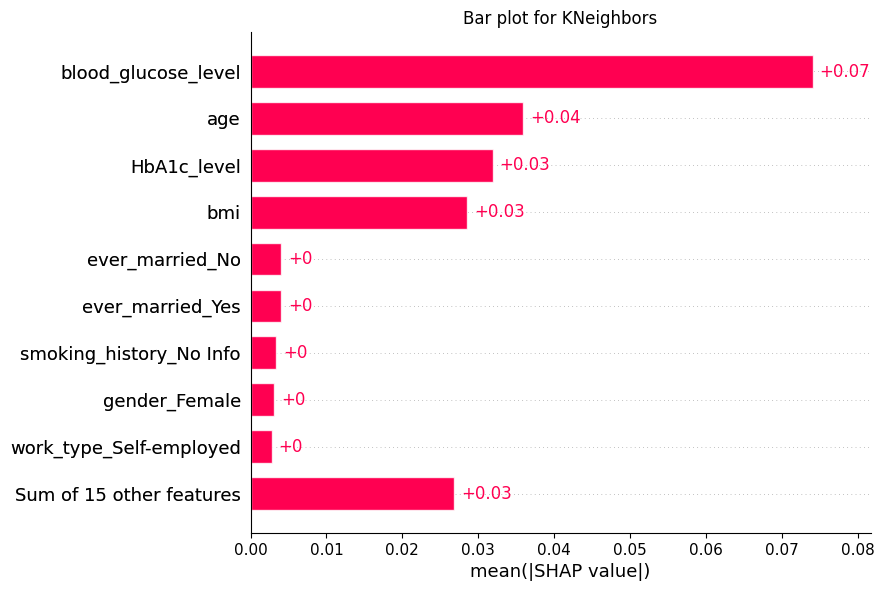

In [32]:
shap.plots.bar(shap_values_k, show=False)
plt.title("Bar plot for KNeighbors")
plt.show()

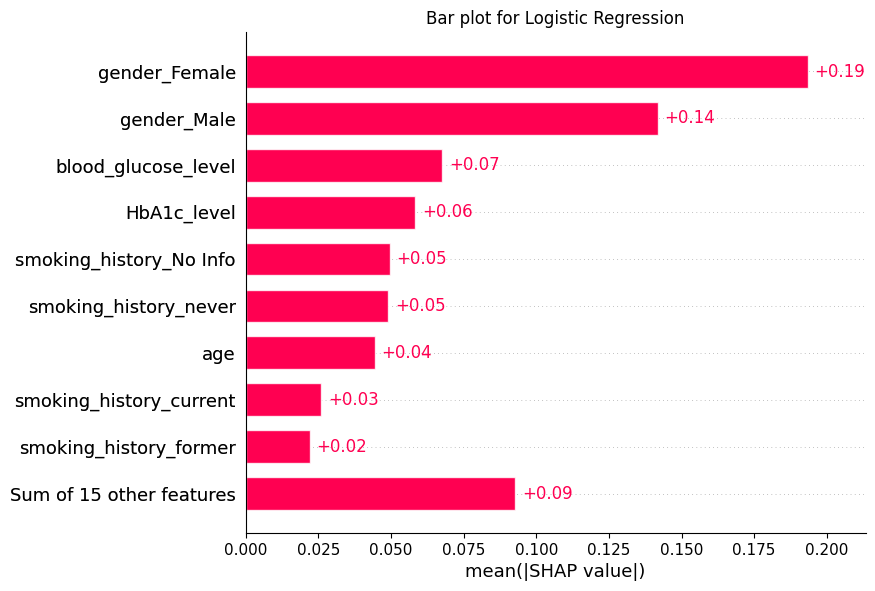

In [33]:
shap.plots.bar(shap_values_linear, show=False)
plt.title("Bar plot for Logistic Regression")
plt.show()

<h1>Beeswarm</h1>
<p>Il grafico del Beeswarm è progettato per rappresentare come le features principali del dataset influiscono sull'output del modello. La posizione x del punto è determinata dal valore SHAP di quella feature e i punti si “accumulano” lungo ciascuna riga della feature per mostrare la densità. Il colore viene utilizzato per visualizzare il valore originale di una feature. 

Gli SHAP values rappresenatano l'importanza dei valori di ogni feature dei record analizzati ai quali viene associato un livello di rilevanza durante l'analisi effetuata con SHAP
</p>

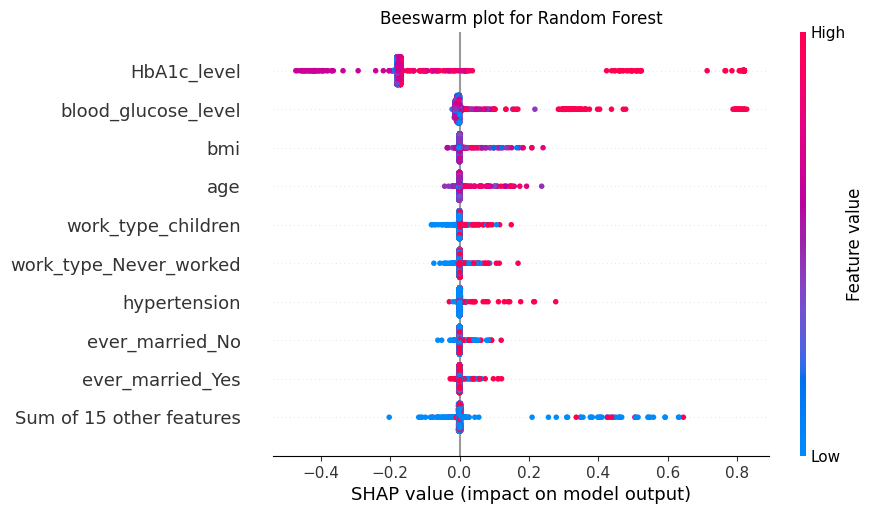

In [34]:
#beeswarm plot for models
shap.plots.beeswarm(shap_values_random_forest, show=False)
plt.title("Beeswarm plot for Random Forest")
plt.show()

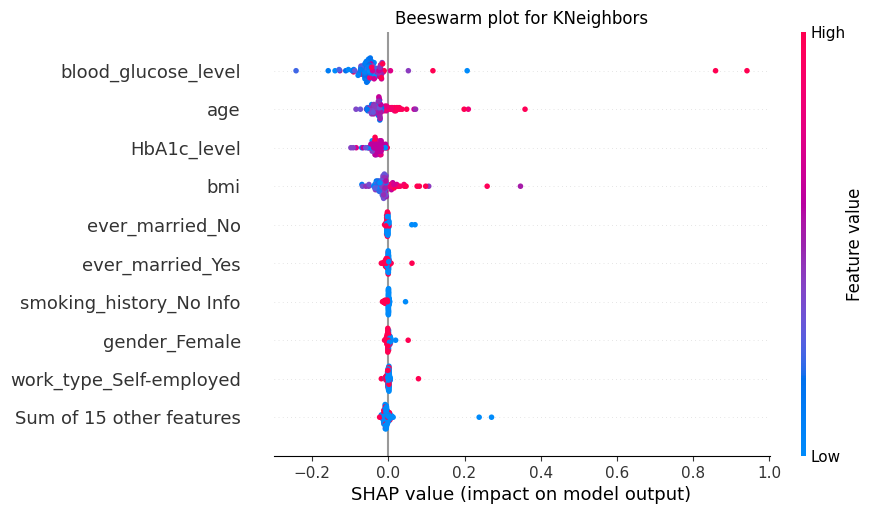

In [35]:
shap.plots.beeswarm(shap_values_k, show=False)
plt.title("Beeswarm plot for KNeighbors")
plt.show()

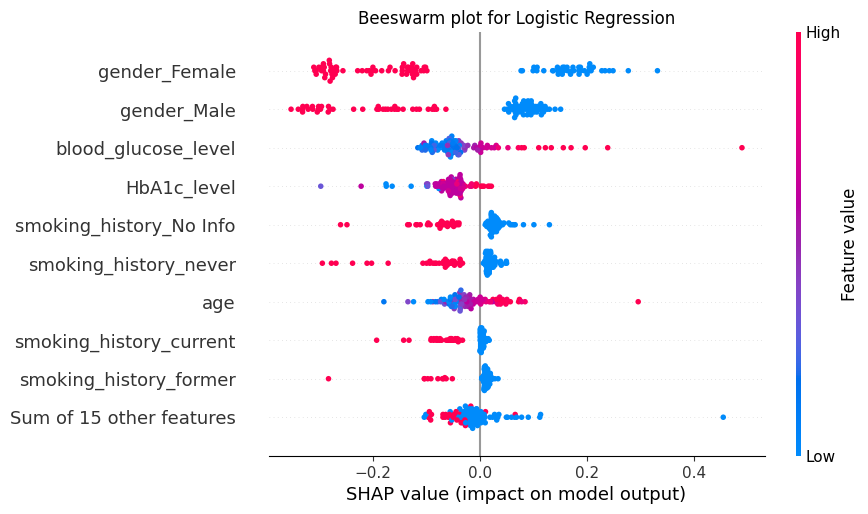

In [36]:
shap.plots.beeswarm(shap_values_linear, show=False)
plt.title("Beeswarm plot for Logistic Regression")
plt.show()

<h1>Conclusioni</h1>
<p>In conclusione con il nostro esperimento possiamo affermare che combinando i due dataset c'è un miglioramento nell'accuratezza e nella recall di alcuni modelli.
Attraverso l'utilizzo della libreria SHAP abbiamo analizzato nello specifico le features più o meno rilevanti per raggiungere e affermare la nostra tesi.</p>

<p>Abbiamo potuto constatare che la presenza della features di HbA1c_level e blood_glocuse_level hanno un legame diretto a livello molecolare.</p>

<p>La presenza di questa molecola rallenta il flusso di ossigeno nel corpo e, quindi, anche al cervello. Questo rallentamento aumenta, inequivocabilmente, il rischio di avere un' ischemia. Questa scoperta ci ha permesso di affermare che la fusione dei due dataset ha avuto un riscontro positvo durante l'analisi attraverso i nostri modelli.</p>